# Entendimento de Negócio

## Contexto

São Petersburgo é a segunda maior cidade russa, o dataset Real Estate Saint Petersburg 2014 - 2019 contém uma rica quantidade de informações sobre o mercado imobiliário local. Os dados incluem variáveis que descrevem tanto os imóveis, quanto a região onde cada um está localizado. 

## Metas e objetivos

Portanto meu objetivo neste projeto é explorar os dados para construir um modelo de machine learning capaz de predizer os preços dos imóveis na cidade. 

# Entendimento dos dados
## Features

|Coluna|Descrição|
|--|--|
|`airports_nearest`|Distância em metros para o aeroporto mais próximo|
|`balcony`| Número de sacadas|
|`ceiling_height`| Altura em metros do telhado|
|`cityCenters_nearest`| Distância até o centro da cidade em metros|
|`days_exposition`| Número de dias que o anúncio esteve ativo|
|`first_day_exposition`| Data de publicação do anúncio|
|`floor`| Total de andares do imóvel|
|`floors_total`| Total de andares no prédio onde o imóvel está localizado|
|`is_apartment`| Se é um apartamento (bool)|
|`kitchen_area`| Área da cozinha em metros quadrados|
|`last_price`| Último preço de anúncio|
|`living_area`| Área de convivência em metros quadrados|
|`locality_name`| Nome da localidade|
|`open_plan`| Se a propriedade tem um plano aberto (bool)|
|`parks_around3000`| Número de parques em um raio de 3km|
|`parks_nearest`| Distância do parque mais próximo em metros|
|`ponds_around3000`| Número de corpos de água em um raio de 3km|
|`ponds_nearest`| Distância do corpo de água mais próximo|
|`rooms`| Número de quartos|
|`studio`| Se é um apartamento do tipo studio (bool)|
|`total_area`| Área total do imóvel em metros quadrados|
|`total_images`| Número de imagens no anúncio|

## Importação de bibliotecas e carregamento dos dados

In [1]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor

import optuna
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from feature_engine.imputation import CategoricalImputer, MeanMedianImputer
from category_encoders import TargetEncoder

import warnings
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fast')
blue_palette = ['#003f5c', '#665191', '#a05195', '#d45087', '#f95d6a', '#ff7c43', '#ffa600']
sns.set_palette(blue_palette)
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv("../data/raw/real_estate_data.csv", sep = '\t')

## Qualidade dos dados

In [4]:
print(f"Dataset possui {df.shape[0]} linhas e {df.shape[1]} colunas.")

Dataset possui 23699 linhas e 22 colunas.


In [5]:
print(f"O dataset possui: {len(df.select_dtypes(include = 'object').columns.to_list())} colunas categóricas.")
print(f"O dataset possui: {len(df.select_dtypes(include = 'number').columns.to_list())} colunas numéricas.")

O dataset possui: 3 colunas categóricas.
O dataset possui: 17 colunas numéricas.


In [6]:
print(f"O dataset possui {df.duplicated().sum()} dados duplicados.")

O dataset possui 0 dados duplicados.


In [7]:
print(f"O dataset possui {df.isnull().sum().sum()} dados nulos.")

O dataset possui 101441 dados nulos.


Vamos checar a proporção de dados nulos em cada coluna. 

In [8]:
df.isnull().mean()

total_images            0.000000
last_price              0.000000
total_area              0.000000
first_day_exposition    0.000000
rooms                   0.000000
ceiling_height          0.387991
floors_total            0.003629
living_area             0.080299
floor                   0.000000
is_apartment            0.882906
studio                  0.000000
open_plan               0.000000
kitchen_area            0.096122
balcony                 0.486054
locality_name           0.002068
airports_nearest        0.233850
cityCenters_nearest     0.232879
parks_around3000        0.232837
parks_nearest           0.659100
ponds_around3000        0.232837
ponds_nearest           0.615596
days_exposition         0.134225
dtype: float64

Podemos usar imputação para as colunas com menos de 30% de dados nulos, penso que seja uma melhor solução não utilizar aquelas com uma proporção maior que essa.

In [9]:
colunas = df.isnull().mean()
filtro = colunas[colunas < 0.30].index
df = df[filtro]
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,floors_total,living_area,floor,studio,open_plan,kitchen_area,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,ponds_around3000,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,16.0,51.0,8,False,False,25.0,Санкт-Петербург,18863.0,16028.0,1.0,2.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,11.0,18.6,1,False,False,11.0,посёлок Шушары,12817.0,18603.0,0.0,0.0,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,5.0,34.3,4,False,False,8.3,Санкт-Петербург,21741.0,13933.0,1.0,2.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,14.0,NaN,9,False,False,NaN,Санкт-Петербург,28098.0,6800.0,2.0,3.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,14.0,32.0,13,False,False,41.0,Санкт-Петербург,31856.0,8098.0,2.0,1.0,121.0


Também é interessante remover variáveis ligadas ao site, e deixar só aquelas ligadas aos imóveis.

In [10]:
df = df.drop(columns = ["total_images", "first_day_exposition", "days_exposition"], axis = 1)
df.head()

,last_price,total_area,rooms,floors_total,living_area,floor,studio,open_plan,kitchen_area,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,ponds_around3000
0,13000000.0,108.0,3,16.0,51.0,8,False,False,25.0,Санкт-Петербург,18863.0,16028.0,1.0,2.0
1,3350000.0,40.4,1,11.0,18.6,1,False,False,11.0,посёлок Шушары,12817.0,18603.0,0.0,0.0
2,5196000.0,56.0,2,5.0,34.3,4,False,False,8.3,Санкт-Петербург,21741.0,13933.0,1.0,2.0
3,64900000.0,159.0,3,14.0,NaN,9,False,False,NaN,Санкт-Петербург,28098.0,6800.0,2.0,3.0
4,10000000.0,100.0,2,14.0,32.0,13,False,False,41.0,Санкт-Петербург,31856.0,8098.0,2.0,1.0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   last_price           23699 non-null  float64
 1   total_area           23699 non-null  float64
 2   rooms                23699 non-null  int64  
 3   floors_total         23613 non-null  float64
 4   living_area          21796 non-null  float64
 5   floor                23699 non-null  int64  
 6   studio               23699 non-null  bool   
 7   open_plan            23699 non-null  bool   
 8   kitchen_area         21421 non-null  float64
 9   locality_name        23650 non-null  object 
 10  airports_nearest     18157 non-null  float64
 11  cityCenters_nearest  18180 non-null  float64
 12  parks_around3000     18181 non-null  float64
 13  ponds_around3000     18181 non-null  float64
dtypes: bool(2), float64(9), int64(2), object(1)
memory usage: 2.2+ MB


## Análise Exploratória de Dados
### Estatísticas descritivas

In [12]:
df.select_dtypes(include = 'number').describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
last_price,23699.0,6541548.77,10887013.27,12190.0,3400000.0,4650000.0,6800000.0,763000000.0
total_area,23699.0,60.35,35.65,12.0,40.0,52.0,69.9,900.0
rooms,23699.0,2.07,1.08,0.0,1.0,2.0,3.0,19.0
floors_total,23613.0,10.67,6.60,1.0,5.0,9.0,16.0,60.0
living_area,21796.0,34.46,22.03,2.0,18.6,30.0,42.3,409.7
floor,23699.0,5.89,4.89,1.0,2.0,4.0,8.0,33.0
kitchen_area,21421.0,10.57,5.91,1.3,7.0,9.1,12.0,112.0
airports_nearest,18157.0,28793.67,12630.88,0.0,18585.0,26726.0,37273.0,84869.0
cityCenters_nearest,18180.0,14191.28,8608.39,181.0,9238.0,13098.5,16293.0,65968.0
parks_around3000,18181.0,0.61,0.80,0.0,0.0,0.0,1.0,3.0


In [13]:
df.select_dtypes(exclude = 'number').describe().T

,count,unique,top,freq
studio,23699,2,False,23550
open_plan,23699,2,False,23632
locality_name,23650,364,Санкт-Петербург,15721


### Correlações

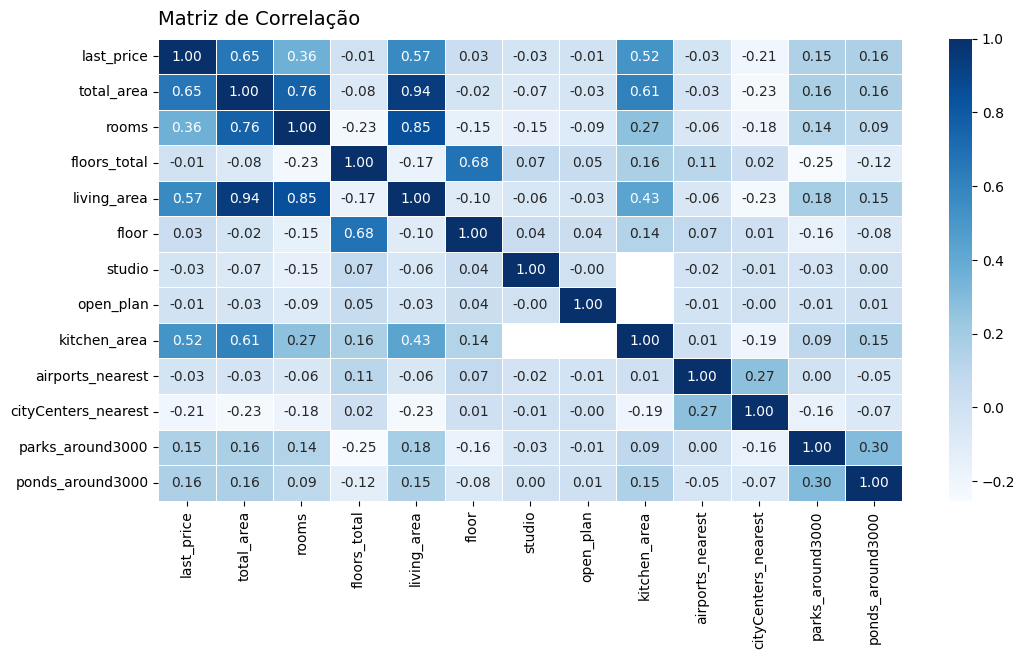

In [14]:
corr = df.corr(numeric_only = True)

fig, ax = plt.subplots(figsize = (12, 6))
sns.heatmap(corr, annot = True, fmt = ".2f", linewidths=0.5, cmap = "Blues")
ax.set_title("Matriz de Correlação", fontsize = 14, pad = 10, loc = "left")
plt.show()

- Dos fatores relacionados a estrutura do imóvel, a área total, tamanho da cozinha e o espaço de convivência são os que mostram correlação mais forte com o preço. A área total no mercado imobiliário sempre uma variável chave na precificação de um imóvel já que o ponto base da avaliação imobiliária é o preço do metro quadrado na região.
- Dentre os outros fatores, estar longe do centro desvaloriza o imóvel, e ter parques e fontes de água próximas valorizam.

### Comportamento do target

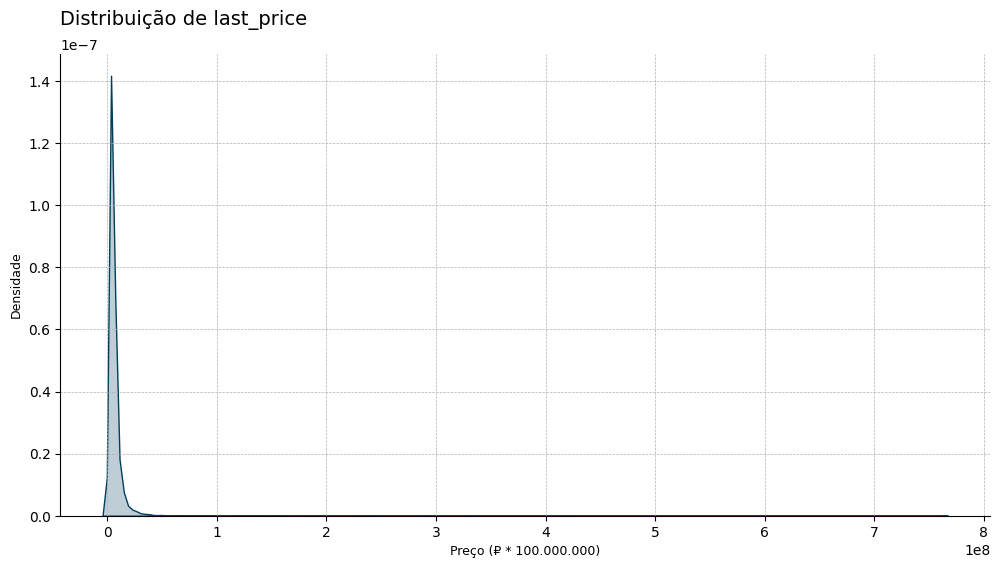

In [15]:
fig , ax = plt.subplots(figsize = (12, 6))

sns.kdeplot(df["last_price"], fill = True)
ax.set_title("Distribuição de last_price", fontsize = 14, pad = 10, loc = "left")
ax.set_xlabel("Preço (₽ * 100.000.000)", fontsize = 9)
ax.set_ylabel("Densidade", fontsize = 9)
ax.grid(True, linestyle = '--', linewidth = 0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

O target apresenta uma assimetria à direita, uma boa solução é uma transformação em $\log$. 

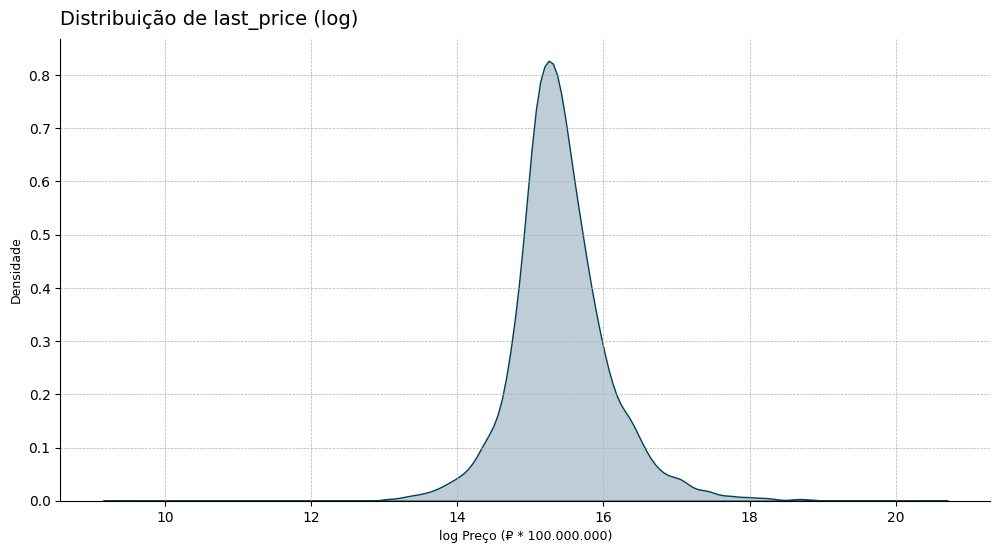

In [16]:
fig , ax = plt.subplots(figsize = (12, 6))

sns.kdeplot(np.log1p(df["last_price"]), fill = True)
ax.set_title("Distribuição de last_price (log)", fontsize = 14, pad = 10, loc = "left")
ax.set_xlabel("log Preço (₽ * 100.000.000)", fontsize = 9)
ax.set_ylabel("Densidade", fontsize = 9)
ax.grid(True, linestyle = '--', linewidth = 0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()


Com a transformação em $\log$ conseguimos uma distribuição próxima à normal. 